# cmip Events

Get the indeces from traditional and EC calcs and determine events

In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches


In [3]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound
import utils.ecIndex as ec
import utils.overlapBins as overlapBins


# Find events in the e and c indeces

 1 sigma above/below mean
Using a piControl climatology

In [3]:
ecXr=xarray.open_dataset('results/cmip6EcIndex.nc')

piControlEcXr=ecXr.sel(experiment='piControl', drop=True)


# This should calculate stds for all experiments and all indeces
stdEcXr = piControlEcXr.std(dim='year')
stdEcXr

<xarray.Dataset>
Dimensions:  (model: 37)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model) float64 0.6734 0.8642 0.7209 ... 0.8357 0.8729 0.7494
    cIndex   (model) float64 0.9206 0.8883 0.8835 ... 0.8652 0.8222 0.8455

Apply the 1 sigma criteria

In [4]:
firePosEc, fireNegEc = compound.applyCriteria(ecXr, stdEcXr)

firePos: 
['cIndex', 'eIndex']
fireNeg: 
[]


In [5]:
# find where either index is saying there is an event
# this is a bit messy, you need to make sure Nan years stay as Nan (years for the piControl is different for all the models)

firePosEc['ecCombined']=(((firePosEc.cIndex+firePosEc.eIndex)>0)*1).where(
        firePosEc.cIndex.isnull()==False)
fireNegEc['ecCombined']=(((fireNegEc.cIndex+fireNegEc.eIndex)>0)*1).where(
    fireNegEc.cIndex.isnull()==False)


In [6]:
firePosEc.sel(experiment='piControl',model='CESM2')

<xarray.Dataset>
Dimensions:     (year: 5341)
Coordinates:
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
    experiment  <U9 'piControl'
    model       <U5 'CESM2'
Data variables:
    cIndex      (year) float64 0.0 0.0 0.0 0.0 1.0 1.0 ... nan nan nan nan nan
    eIndex      (year) float64 1.0 0.0 0.0 1.0 0.0 0.0 ... nan nan nan nan nan
    ecCombined  (year) float64 1.0 0.0 0.0 1.0 1.0 1.0 ... nan nan nan nan nan

In [7]:
#Find events in the trad indeces

In [8]:
tradIndecesXr = xarray.concat([
    xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc') for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [9]:
tradIndecesXr

<xarray.Dataset>
Dimensions:                 (experiment: 2, model: 37, year: 5341)
Coordinates:
  * year                    (year) int64 1 2 3 4 5 ... 7889 7890 7891 7892 7893
  * model                   (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
  * experiment              (experiment) <U9 'piControl' 'ssp585'
Data variables: (12/18)
    eastIONoDetrend         (experiment, model, year) float64 nan nan ... nan
    nino34                  (experiment, model, year) float64 nan nan ... nan
    eastIO                  (experiment, model, year) float64 nan nan ... nan
    backgroundSstNoDetrend  (experiment, model, year) float64 nan nan ... nan
    nino4                   (experiment, model, year) float64 nan nan ... nan
    westIO                  (experiment, model, year) float64 nan nan ... nan
    ...                      ...
    dmiNoDetrend            (experiment, model, year) float64 nan nan ... nan
    dmirollingDetrend       (experiment, model, year) float64 nan nan ... nan
    eastIOrollingDetrend    (experiment, model, year) float64 nan nan ... nan
    nino34rollingDetrend    (experiment, model, year) float64 nan nan ... nan
    westIOrollingDetrend    (experiment, model, year) float64 nan nan ... nan
    nino4rollingDetrend     (experiment, model, year) float64 nan nan ... nan

In [10]:
piControlXr=tradIndecesXr.sel(experiment='piControl',drop=True)

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [11]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['nino34','nino4','dmi','eastIO']],
     stdXr[['samWinter','samSummer']]/2)
)

In [12]:
firePosTrad, fireNegTrad = compound.applyCriteria(tradIndecesXr, criteriaXr)


firePos: 
['dmi', 'nino4', 'samWinter', 'nino34']
fireNeg: 
['eastIO', 'samSummer']


Now we can merge the events from each method

In [13]:
firePos=xarray.merge([firePosEc,firePosTrad])
fireNeg=xarray.merge([fireNegEc,fireNegTrad])

In [14]:
firePos

<xarray.Dataset>
Dimensions:     (experiment: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    cIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    eIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    ecCombined  (model, experiment, year) float64 nan nan nan ... nan nan nan
    dmi         (experiment, model, year) float64 nan nan nan ... nan nan nan
    nino4       (experiment, model, year) float64 nan nan nan ... nan nan nan
    samWinter   (experiment, model, year) float64 nan nan nan ... nan nan nan
    nino34      (experiment, model, year) float64 nan nan nan ... nan nan nan
    eastIO      (experiment, model, year) float64 nan nan nan ... nan nan nan
    samSummer   (experiment, model, year) float64 nan nan nan ... nan nan nan

In [15]:
fireXr=xarray.concat([firePos,fireNeg], 'fire')
fireXr['fire']=['pos','neg']

fireXr.to_netcdf('results/cmipEcEvents.nc')


# Put the resutls in 30 year bins

In [4]:
fireXr=xarray.open_dataset('results/cmipEcEvents.nc')

In [5]:
#ssp585
fireBinnedXr=overlapBins.binSum(fireXr.sel(experiment='ssp585', year=slice(1850,2100),drop=True))


In [6]:
fireBinnedXr

<xarray.Dataset>
Dimensions:     (fire: 2, model: 37, year: 23)
Coordinates:
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
  * year        (year) int64 1865 1875 1885 1895 1905 ... 2055 2065 2075 2085
Data variables:
    cIndex      (year, fire, model) float64 29.0 23.0 6.0 5.0 ... 5.0 4.0 3.0
    eIndex      (year, fire, model) float64 2.0 9.0 5.0 6.0 ... 2.0 8.0 11.0 1.0
    ecCombined  (year, fire, model) float64 29.0 26.0 9.0 9.0 ... 10.0 13.0 3.0
    dmi         (year, fire, model) float64 7.0 2.0 4.0 5.0 ... 1.0 0.0 0.0 0.0
    nino4       (year, fire, model) float64 5.0 2.0 5.0 6.0 ... 3.0 7.0 7.0 2.0
    samWinter   (year, fire, model) float64 5.0 11.0 12.0 13.0 ... 0.0 0.0 0.0
    nino34      (year, fire, model) float64 6.0 2.0 4.0 4.0 ... 3.0 9.0 10.0 2.0
    eastIO      (year, fire, model) float64 7.0 4.0 4.0 4.0 ... 4.0 4.0 3.0 0.0
    samSummer   (year, fire, model) float64 14.0 6.0 11.0 ... 29.0 30.0 30.0
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [7]:
# and for piControl
binSumLs = list()

#using bin sum is a bit funky because the models have different start and end years
#run binSum for each model seperately, after filtering the nans
for iModel in _model.scenarioMip[:,1]:
    try:
        piCModelXr=fireXr.sel(experiment='piControl', drop=True).sel(model=iModel)
        binSumXr=overlapBins.binSum(piCModelXr.where(piCModelXr.isnull()==False, drop=True))
        binSumLs.append(binSumXr)
        
    except Exception as e:
        print(e)
        
piControlBinnedXr = xarray.concat(binSumLs, 'model')

In [8]:
piControlBinnedXr

<xarray.Dataset>
Dimensions:     (fire: 2, model: 37, year: 851)
Coordinates:
  * year        (year) int64 16 26 36 46 56 66 ... 7825 7835 7845 7855 7865 7875
  * model       (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) object 'pos' 'neg'
Data variables:
    cIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    eIndex      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    ecCombined  (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    dmi         (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino4       (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samWinter   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    nino34      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    eastIO      (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
    samSummer   (model, year, fire) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

In [9]:
firePosBinnedXr=fireBinnedXr.sel(fire='pos', drop=True)
piControlPosBinnedXr=piControlBinnedXr.sel(fire='pos', drop=True)

fireNegBinnedXr=fireBinnedXr.sel(fire='neg', drop=True)
piControlNegBinnedXr=piControlBinnedXr.sel(fire='neg', drop=True)

# Index Comparisons - ENSO

In [22]:
%run utils/emergence.ipynb

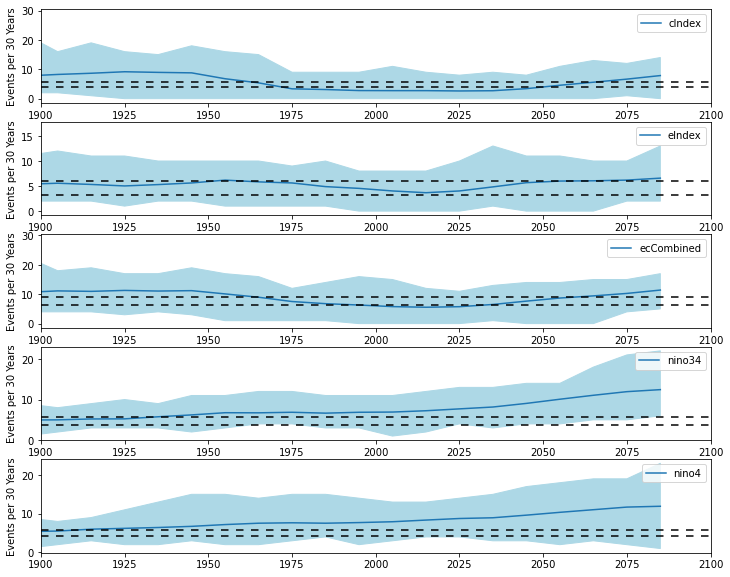

In [23]:
emergePlot(
    firePosBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']],
    piControlPosBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']]
      )
plt.show()

And with the reduced model set from wang et al

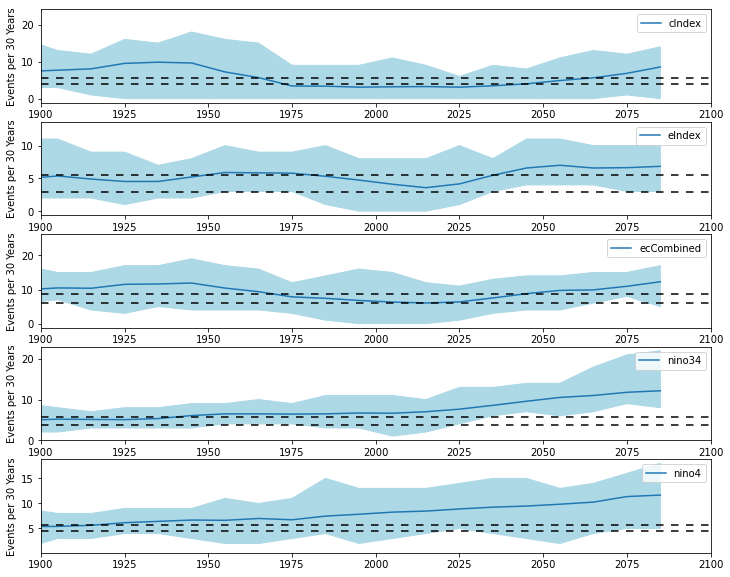

In [24]:
emergePlot(
    firePosBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']].sel(model=_model.wangModelSet),
    piControlPosBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']].sel(model=_model.wangModelSet)
      )
plt.show()

And the negative case

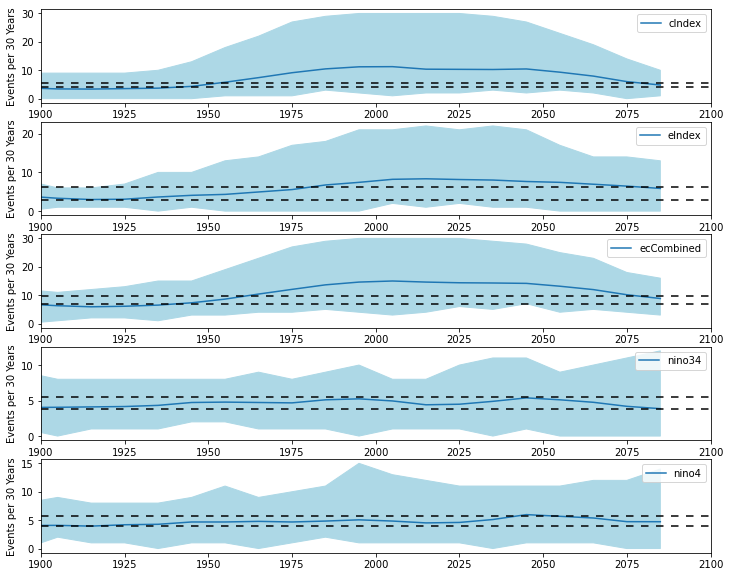

In [25]:
emergePlot(fireNegBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']],
piControlNegBinnedXr[['cIndex','eIndex','ecCombined','nino34','nino4']]
      )
plt.show()

 time of emergence by model and index

# Index Comparisons - ENSO

In [26]:
%run utils/emergence.ipynb

Text(0, 0.5, 'index')

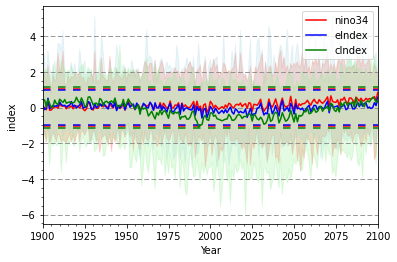

In [27]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).nino34,
        ecXr.sel(experiment='ssp585',drop=True)
    ]), 
    xarray.merge([
        tradIndecesXr.sel(experiment='piControl',drop=True).nino34,
        ecXr.sel(experiment='piControl',drop=True)
    ])
)

plt.xlim([1900,2100])
plt.ylabel('index')

In [28]:
tradIndecesXr.sel(model=iModel).nino34

<xarray.DataArray 'nino34' (experiment: 2, year: 5341)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
    model       <U11 'UKESM1-0-LL'
  * experiment  (experiment) <U9 'piControl' 'ssp585'

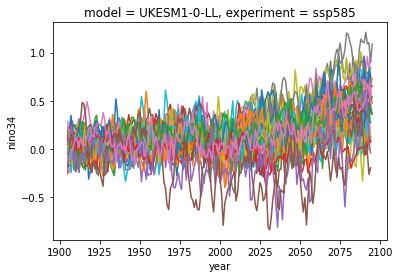

In [29]:
for iModel in tradIndecesXr.model.values:
    tradIndecesXr.sel(
        model=iModel, experiment='ssp585', year=slice(1900,2100)
    ).nino34.rolling(year=11,center=True).mean('year').plot()


Text(0, 0.5, 'index')

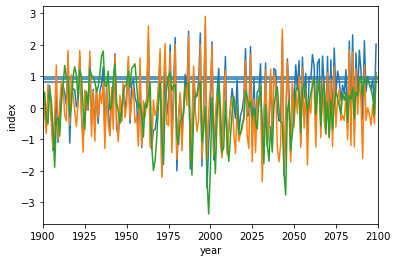

In [30]:
tradIndecesXr.sel(experiment='ssp585',model='CESM2',drop=True).nino34.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).eIndex.plot()
ecXr.sel(experiment='ssp585',model='CESM2',drop=True).cIndex.plot()

plt.hlines(
    [
        stdEcXr.eIndex.sel(model='CESM2'),
        stdEcXr.cIndex.sel(model='CESM2'),
        stdXr.nino34.sel(model='CESM2')
    ],
    1900,2100
)

plt.xlim([1900,2100])
plt.ylabel('index')

# Index Comparisons - IOD

In [31]:
firePosBinnedXr

<xarray.Dataset>
Dimensions:     (model: 37, year: 23)
Coordinates:
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * year        (year) int64 1865 1875 1885 1895 1905 ... 2055 2065 2075 2085
Data variables:
    cIndex      (year, model) float64 29.0 23.0 6.0 5.0 ... 8.0 13.0 12.0 7.0
    eIndex      (year, model) float64 2.0 9.0 5.0 6.0 3.0 ... 7.0 6.0 7.0 6.0
    ecCombined  (year, model) float64 29.0 26.0 9.0 9.0 ... 11.0 13.0 13.0 8.0
    dmi         (year, model) float64 7.0 2.0 4.0 5.0 6.0 ... 5.0 18.0 21.0 22.0
    nino4       (year, model) float64 5.0 2.0 5.0 6.0 4.0 ... 7.0 12.0 10.0 13.0
    samWinter   (year, model) float64 5.0 11.0 12.0 13.0 ... 27.0 29.0 29.0 30.0
    nino34      (year, model) float64 6.0 2.0 4.0 4.0 4.0 ... 6.0 10.0 9.0 11.0
    eastIO      (year, model) float64 7.0 4.0 4.0 4.0 6.0 ... 2.0 19.0 20.0 22.0
    samSummer   (year, model) float64 14.0 6.0 11.0 10.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Bins:     Overlapping 30 year bins, seperating by 10 year intervals
    Year:     Midpoint of bin

(1900.0, 2085.0)

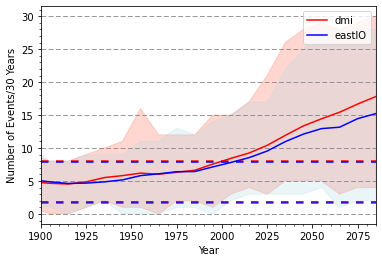

In [32]:
overlaidEmergePlot(
    firePosBinnedXr[['dmi','eastIO']],
    piControlPosBinnedXr[['dmi','eastIO']]
      )

plt.xlim([1900,2085])


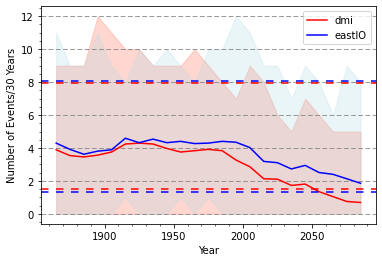

In [33]:
overlaidEmergePlot(
    fireNegBinnedXr[['dmi','eastIO']],
    piControlNegBinnedXr[['dmi','eastIO']]
      )
plt.show()

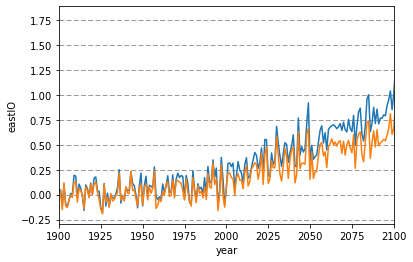

In [34]:
tradIndecesXr.sel(experiment='ssp585',drop=True).dmi.mean('model').plot()
(tradIndecesXr.sel(experiment='ssp585',drop=True).eastIO.mean('model')*-1).plot()
plt.xlim([1900,2100])
plt.grid(axis='y', color='grey', dashes=[6,3])


Text(0, 0.5, 'index')

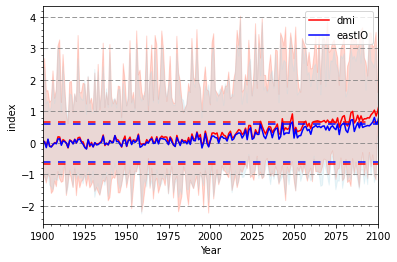

In [35]:
overlaidEmergePlot(
    xarray.merge([
        tradIndecesXr.sel(experiment='ssp585',drop=True).dmi,
        (tradIndecesXr.sel(experiment='ssp585',drop=True).eastIO*-1)
    ]), 
    xarray.merge([
        tradIndecesXr.sel(experiment='piControl',drop=True).dmi,
        (tradIndecesXr.sel(experiment='piControl',drop=True).eastIO*-1)
    ])
)

plt.xlim([1900,2100])
plt.ylabel('index')

# How do they look when compounded?

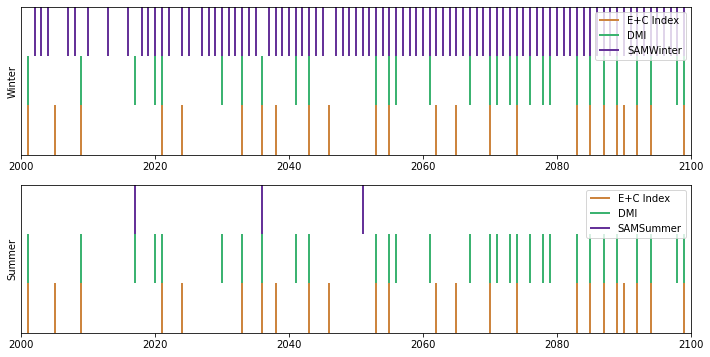

In [11]:
plt.figure(figsize=(12,6))

colors = ['peru', 'mediumseagreen', 'rebeccapurple']
indeces = ['ecCombined','dmi','samWinter']

toPlot=fireXr.sel(
    fire='pos',
    experiment='ssp585',
    year=slice(1900,2099),
    model='CESM2',
    drop=True
)

plt.subplot(2,1,1)

iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
plt.legend(['E+C Index','DMI','SAMWinter'])
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Winter')


plt.subplot(2,1,2)

indeces = ['ecCombined','dmi','samSummer']


iPlot=0
for iIndex in indeces:
    plt.vlines(
        x=toPlot[iIndex].where(toPlot[iIndex],drop=True).year, 
        ymin=iPlot,
        ymax=(iPlot+1),#*(toPlot[iIndex].where(toPlot[iIndex])),
        color=colors[iPlot], 
        linewidth=2
    )
    iPlot=iPlot+1
plt.legend(['E+C Index','DMI','SAMSummer'])
plt.xlim(2000,2100)
plt.ylim([0,3])
plt.yticks([])
plt.ylabel('Summer')

plt.savefig('figures/cmip6compoundExampleDry.pdf')

# Calculate the compounding years

In [37]:
allCompoundsXr=xarray.concat([
    compound.compound(firePos),
    compound.compound(fireNeg)],
    'fire')

allCompoundsXr['fire']=['pos','neg']



cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
cIndexEastioSamwinter
cIndexEastioSamsummer
nino34DmiSamwinter
nino34DmiSamsummer
nino34EastioSamwinter
nino34EastioSamsummer
nino4DmiSamwinter
nino4DmiSamsummer
nino4EastioSamwinter
nino4EastioSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
ecCombinedEastioSamwinter
ecCombinedEastioSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
eIndexEastioSamwinter
eIndexEastioSamsummer


That is a bit of a crazy long list, so well be a little bit selective

In [38]:
compoundNames= [
    #'nino4EastioSamwinter',
    #'nino4EastioSamsummer',
    #'nino4DmiSamwinter',
    #'nino4DmiSamsummer',
    'nino34EastioSamwinter',
    'nino34EastioSamsummer',
    'nino34DmiSamwinter',
    'nino34DmiSamsummer',
    'cIndexEastioSamwinter',
    'cIndexEastioSamsummer',
    'cIndexDmiSamwinter',
    'cIndexDmiSamsummer',
    'eIndexEastioSamwinter',
    'eIndexEastioSamsummer',
    'eIndexDmiSamwinter',
    'eIndexDmiSamsummer',
    'ecCombinedEastioSamwinter',
    'ecCombinedEastioSamsummer',
    'ecCombinedDmiSamwinter',
    'ecCombinedDmiSamsummer'
]

In [39]:
allCompoundsXr[compoundNames].to_netcdf('results/cmip6Compounds.nc') 